In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import camb as camb
from scipy.interpolate import interp1d

In [3]:
side = 500
spacing = 5
n_cells = side // spacing 

Volume = side**3

In [4]:
knorm = []
for i in range(n_cells):
    kx = i if i <= n_cells //2 else i-n_cells       ## this is due to the ordering in kx, ky: positive k first, then negative
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j<= n_cells // 2 else j-n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1):               ## by construction z contains only positive values of k
            kz = k * 2*np.pi/side
            knorm.append(np.sqrt(kx**2+ky**2+kz**2))

In [5]:
kx = np.fft.fftfreq(n_cells, spacing) * 2*np.pi
ky = np.fft.fftfreq(n_cells, spacing) * 2*np.pi
kz = np.fft.rfftfreq(n_cells, spacing) * 2*np.pi

kxx, kyy, kzz = np.meshgrid(kx, ky, kz, indexing='ij')

KNORM = np.sqrt(kxx**2 + kyy**2 + kzz**2)

In [6]:
KNORM.flatten()==np.array(knorm)

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
Omega_b= 0.05
Omega_c = 0.25

h=0.7
As = 2.1e-09
ns = 0.96

pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2)
pars.InitPower.set_params(As=As, ns=ns)

pars.set_matter_power(redshifts=[10.], kmax=10.)
result = camb.get_results(pars)

kh, z, pk = result.get_matter_power_spectrum(minkh=1.e-4, maxkh=10, npoints=512)

pk_interpolate = interp1d(kh, pk[0], kind='cubic', fill_value="extrapolate")

In [8]:
pk_interpolate(KNORM.flatten())==pk_interpolate(knorm)

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
pk_interpolate(knorm).reshape(n_cells, n_cells, n_cells//2+1)==pk_interpolate(KNORM)

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [10]:
pks = pk_interpolate(KNORM)#.reshape(n_cells, n_cells, n_cells//2+1)
xi = np.fft.irfftn(pks) / spacing**3

if np.any(xi <= -1):
    raise ValueError("Invalid input: xi contains elements <= -1")
# generate gaussian 2PCF

xi.shape

# generate gaussian 2PCF
xi_g = np.log(1+xi)

# get PS from xi_g

pk_g = np.fft.rfftn(xi_g) * spacing**3

phase = np.random.uniform(size=pks.shape)*2*np.pi
G_k_norm = np.random.normal(size=pks.shape)*np.sqrt(pk_g*Volume)
G_k_norm[0,0,0] = 0

G_k = G_k_norm *(np.cos(phase)+1j*np.sin(phase))

G_x = np.fft.irfftn(G_k, norm='backward')/spacing**3

# get delta from G_x using lognormal transform
var_G = np.var(G_x)
delta_x = np.exp(G_x-var_G)-1

Text(0.5, 1.0, 'G(x)')

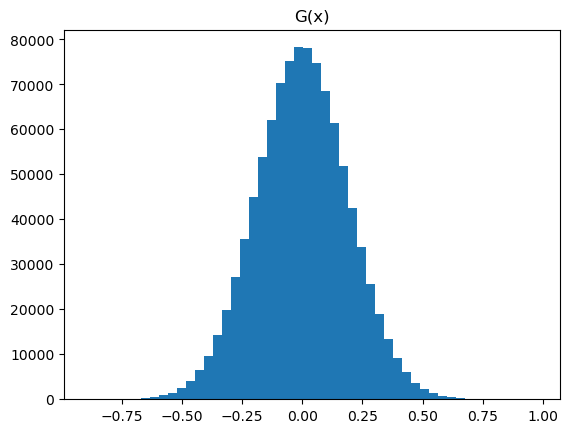

In [11]:
plt.hist(G_x.flatten(), histtype="bar", bins=50)
plt.title('G(x)')

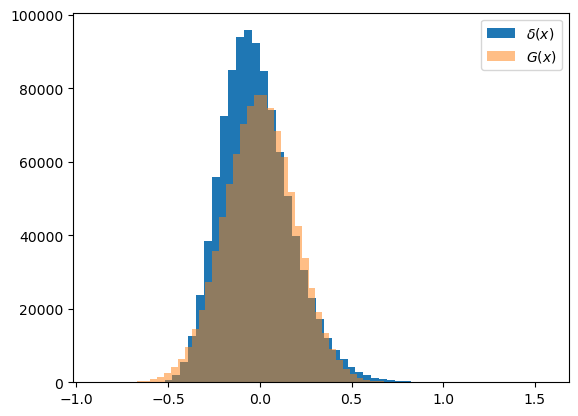

In [12]:
plt.hist(delta_x.flatten(), histtype="bar", bins=50, label='$\delta(x)$')
plt.hist(G_x.flatten(), histtype="bar", bins=50, alpha=0.5, label='$G(x)$')
plt.legend()